# Finding adversarial examples, in depth

In the quickstart, we used the default parameters for `find_adversarial_example`. Using the same example from the quickstart, we explore how to get more out of the function.

In [1]:
using MIPVerify
using Gurobi
using JuMP
using Images

mnist = MIPVerify.read_datasets("MNIST")
n1 = MIPVerify.get_example_network_params("MNIST.n1")
sample_image = MIPVerify.get_image(mnist.train.images, 1);

function print_summary(d::Dict)
    # Helper function to print out output
    obj_val = getobjectivevalue(d[:Model])
    solve_time = getsolvetime(d[:Model])
    println("Objective Value: $(@sprintf("%.6f", obj_val)), Solve Time: $(@sprintf("%.2f", solve_time))")
end

function view_diff(diff::Array{<:Real, 2})
    n = 1001
    colormap("RdBu", n)[ceil.(Int, (diff+1)/2*n)]
end;

## `find_adversarial_example`

`find_adversarial_example` takes four positional arguments

```
find_adversarial_example(nn, input, target_selection, main_solver)
```

It also takes named arguments, each with the default value specified.

```
norm_order = 1
tolerance = 0
rebuild = false
invert_target_selection = false
pp = MIPVerify.UnrestrictedPerturbationFamily()
tightening_algorithm = lp
tightening_solver: same as main solver, but with output suppressed and a time limit of 20s per solve.
```

We explore what each of these options allow us to do.

# Basic Options

## Specifying target categories for the adversarial example

`target_selection` and `invert_target_selection` control what the category we want the adversarial example to be classified in.

**Specification**: `target_selection` accepts either a single integer or a list of integers.

For example, if I wanted the original image (which is the digit 7) to be classified as the digit 0 or 8, I could run two separate solves with `target_selection=1` and `target_selection=9` (Julia is 1-indexed), finding closest adversarial examples at distance `15.0926` and `9.75700` ...

In [2]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 1, GurobiSolver(OutputFlag=0))
# OutputFlag=0 prevents any output from being printed out
print_summary(d)

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1]
Academic license - for non-commercial use only
Objective Value: 15.092612, Solve Time: 41.72


In [3]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 9, GurobiSolver(OutputFlag=0));
print_summary(d)

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [9]
Academic license - for non-commercial use only
Objective Value: 9.756997, Solve Time: 6.06


Or I can can pass the targets as  `target_selection = [1, 9]`, where the same optimal value of `9.757` is found.

Solve times for multiple target labels are typically on par with or faster than the aggregate solve times when solving with each target label in sequence.

In [4]:
d = MIPVerify.find_adversarial_example(n1, sample_image, [1, 9], GurobiSolver(OutputFlag=0));
print_summary(d)

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 9]
Academic license - for non-commercial use only
Objective Value: 9.756997, Solve Time: 19.85


A common use case is to have the adversarial example being in any category but the original:

In [5]:
d = MIPVerify.find_adversarial_example(n1, sample_image, [1, 2, 3, 4, 5, 6, 7, 9, 10], GurobiSolver(OutputFlag=0))
print_summary(d)

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 2, 3, 4, 5, 6, 7, 9, 10]
Academic license - for non-commercial use only
Objective Value: 3.171856, Solve Time: 21.20


Rather than typing the full list of other categories, we can set `target_selection = 8`, and `invert_target_selection = true`.

In [6]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 8, GurobiSolver(OutputFlag=0), 
    invert_target_selection=true)
print_summary(d)

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 2, 3, 4, 5, 6, 7, 9, 10]
Academic license - for non-commercial use only
Objective Value: 3.171856, Solve Time: 21.14


## More precise control over activations in output layer
### Default Behavior
The default option for `tolerance` is 0. This means that the activations in the softmax layer will take its maximum value for the target label (or at least one of them if more than one is specified), but that this maximum may not be unique.

In the example below, notice how the activations `y[8]` and `y[10]` (corresponding to labels 7 and 9) are equal, at 3.49171.

In [7]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0))
print_summary(d)
perturbed_sample_image = getvalue(d[:PerturbedInput])
y = perturbed_sample_image |> n1

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
Objective Value: 3.171856, Solve Time: 6.06


10-element Array{Float64,1}:
 0.388105
 0.515855
 1.25875 
 0.296821
 0.410448
 0.556019
 0.444605
 3.49171 
 0.412949
 3.49171 

### Ensuring difference in activation between target labels and non-target labels

If we want to ensure that the maximum is unique, we can add a small tolerance. This is the minimum difference between the activation of the target label (or the maximum activation of any of the target labels) and any non-target label. In the example below, with a tolerance of 0.001, notice how `y[8] = 3.49243 = 0.00100 + 3.49143 = tolerance + y[10]`.

_This increases the objective value slightly (since the closest adversarial example with the required tolerance must be slightly further away.)_

In [8]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0), 
    tolerance = 0.001)
print_summary(d)
perturbed_sample_image = getvalue(d[:PerturbedInput])
y = perturbed_sample_image |> n1

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
Objective Value: 3.172870, Solve Time: 2.98


10-element Array{Float64,1}:
 0.388176
 0.515929
 1.2587  
 0.296866
 0.410472
 0.556048
 0.444678
 3.49143 
 0.41283 
 3.49243 

## Restricting the Family of Perturbations

### Unrestricted Perturbations

The standard threat model is to allow each pixel to be perturbed independently, which is what happens by default:

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
  6.137796 seconds (345.73 k allocations: 18.421 MiB, 0.18% gc time)


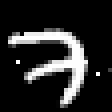

In [9]:
d = @time MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0));
perturbed_sample_image = getvalue(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

### $L_\infty$-norm Bounded Perturbations

We can bound the $L_\infty$-norm of the perturbation.

As long as the size of the $L_\infty$-norm bound we choose is larger than the actual ($L_\infty$-)minimal perturbation, we will find the same result, and often more quickly.

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
  1.352921 seconds (378.67 k allocations: 28.432 MiB, 0.88% gc time)


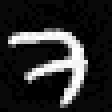

In [34]:
d = @time MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0),
    norm_order=Inf);
perturbed_sample_image = getvalue(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
  1.239649 seconds (300.38 k allocations: 25.335 MiB, 0.97% gc time)


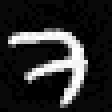

In [35]:
d = @time MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.05), norm_order=Inf);
perturbed_sample_image = getvalue(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

If the $L_\infty$-norm bound you choose is smaller than the actual minimal perturbation, the problem is Infeasible, with a status code of either `:Infeasible` or `:InfeasibleOrUnbounded`. (Make sure you cover both cases!)

In [39]:
d = @time MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.03), norm_order=Inf);

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
  0.201240 seconds (284.80 k allocations: 24.587 MiB, 4.80% gc time)


In [41]:
d[:SolveStatus]

:Infeasible

### Blurring Perturbations

We can restrict the perturbations to a blur with a 5x5 kernel instead. (We are still minimizing over the norm of the perturbation.)

[notice | MIPVerify]: Rebuilding model from scratch. This may take some time as we determine upper and lower bounds for the input to each non-linear unit. The model built will be cached and re-used for future solves, unless you explicitly set rebuild=true.


  Calculating upper bounds:  65%|███████████████        |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:01


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds:  50%|████████████           |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds:  80%|██████████████████     |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:01


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:01


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
  6.403268 seconds (2.21 M allocations: 466.652 MiB, 1.01% gc time)


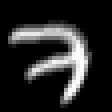

In [10]:
d = @time MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0),
    pp = MIPVerify.BlurringPerturbationFamily((5, 5)));
perturbed_sample_image = getvalue(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

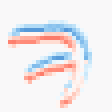

In [11]:
diff = getvalue(d[:Perturbation])
view_diff(diff[1, :, :, 1])

## Minimizing Over Different Norms
### $l_1$
By default, we minimize the $l_1$ norm of the perturbation. This generally encourages sparsity in the perturbations. 

In this case, the minimum $l_1$ norm perturbation required for the image to be classified as a `9` is `3.171856.`

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
Objective Value: 3.171856, Solve Time: 6.33


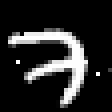

In [12]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0));
print_summary(d)
perturbed_sample_image = getvalue(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

We also show the difference between the perturbed image and the original image. Red is areas of decreased brightness and blue is areas of increased brightness.

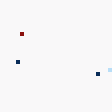

In [13]:
diff = getvalue(d[:Perturbation])
view_diff(diff[1, :, :, 1])

### $l_\infty$

We can also minimize over the $l_\infty$ norm. This generally results in large patches of the image being changed. 

In this case, the minimum $l_\infty$ norm perturbation required for the image to be classified as a `9` is `0.033522.`

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
Objective Value: 0.033522, Solve Time: 1.36


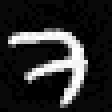

In [14]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0),
    norm_order=Inf);
print_summary(d)
perturbed_sample_image = getvalue(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

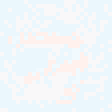

In [15]:
diff = getvalue(d[:Perturbation])
view_diff(diff[1, :, :, 1])

### $l_2$
With solvers that can handle MIQPs (like Gurobi), we can minimize over the $l_2$ norm. This generally takes a bit more time. 

In this case, the minimum $l_2$ norm perturbation required for the image to be classified as a `9` is `0.183 = sqrt(0.033522).`

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
Objective Value: 0.328904, Solve Time: 10.42


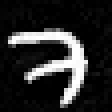

In [16]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0),
    norm_order=2);
print_summary(d)
perturbed_sample_image = getvalue(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

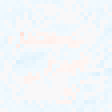

In [17]:
diff = getvalue(d[:Perturbation])
view_diff(diff[1, :, :, 1])

# Advanced Options

## Models
Finding adversarial examples consists of two steps:

  1. Building a model that expresses the input-output constraints of the neural net, which involves determining upper and lower bounds on each intermediate value.
  2. Setting a target category (or multiple target categories) and solving to determine the minimal adversarial example that is classified in that category.

The first time we verify a neural net, we must do step 1, which can take a long time.

In [18]:
d = @time MIPVerify.find_adversarial_example(n1, sample_image, 1, GurobiSolver(OutputFlag=0), rebuild=true);
print_summary(d)

[notice | MIPVerify]: Rebuilding model from scratch. This may take some time as we determine upper and lower bounds for the input to each non-linear unit. The model built will be cached and re-used for future solves, unless you explicitly set rebuild=true.
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial 

  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds:  25%|██████                 |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
 44.634717 seconds (795.48 k allocations: 328.480 MiB, 0.07% gc time)
Objective Value: 15.092612, Solve Time: 43.29


When re-running the solve (with the `rebuild` parameter defaulting to `false`), we load the model from cache and skip ahead straight to step 2; finding the adversarial example takes much less time.

In [19]:
d = @time MIPVerify.find_adversarial_example(n1, sample_image, 1, GurobiSolver(OutputFlag=0));
print_summary(d)

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1]
Academic license - for non-commercial use only
 40.653519 seconds (345.64 k allocations: 18.414 MiB, 0.01% gc time)
Objective Value: 15.092612, Solve Time: 40.60


By setting `rebuild=true`, you force the MIP model to be rebuilt even if one exists; this is potentially useful if you want to spend more time expressing the neural net as an MIP model to speed up subsequent solves. (Think of this as an investment!)

### Removing Cached Models

If you find that your cached models are taking up too much space, you can remove them with `remove_cached_models()`.

## Advanced Solver-fu

We use two different solvers for the two steps of finding adversarial examples:

  1. the `tightening_solver`, used only to determine upper and lower bounds on intermediate values when expressing the input-output constraints in the neural net (i.e. if no cached model exists, or if `rebuild=true`), and 
  2. the `main_solver`, used to determine the minimal adversarial example for the loaded model.

### `tightening_algorithm`

By default, we tighten the bounds on each intermediate value by solving an LP using the `tightening_solver`. Compare total solve times for three different tightening algorithms:

In [20]:
MIPVerify.setloglevel!("notice")
@time MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0), rebuild=true,
    tightening_algorithm=interval_arithmetic);

[notice | MIPVerify]: Rebuilding model from scratch. This may take some time as we determine upper and lower bounds for the input to each non-linear unit. The model built will be cached and re-used for future solves, unless you explicitly set rebuild=true.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
  6.212136 seconds (463.23 k allocations: 24.769 MiB, 0.11% gc time)


In [21]:
MIPVerify.setloglevel!("notice")
@time MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0), rebuild=true,
    tightening_algorithm=lp);

[notice | MIPVerify]: Rebuilding model from scratch. This may take some time as we determine upper and lower bounds for the input to each non-linear unit. The model built will be cached and re-used for future solves, unless you explicitly set rebuild=true.
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial 

  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds:  80%|██████████████████     |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
  7.603950 seconds (789.99 k allocations: 328.161 MiB, 0.43% gc time)


In [22]:
MIPVerify.setloglevel!("notice")
@time MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0), rebuild=true,
    tightening_algorithm=mip);

[notice | MIPVerify]: Rebuilding model from scratch. This may take some time as we determine upper and lower bounds for the input to each non-linear unit. The model built will be cached and re-used for future solves, unless you explicitly set rebuild=true.
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:23
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:46


[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
 75.074227 seconds (505.86 k allocations: 57.580 MiB, 0.03% gc time)


We can also modify many of the parameters of the solver to change behavior:

We will be focusing on the parameters available via Gurobi (http://www.gurobi.com/documentation/7.5/refman/parameters.html), but other solvers often have similar options.

  
### `main_solver`

#### Muting Output
To mute the output from the `GurobiSolver`, set `OutputFlag=0`.


In [23]:
d = MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver());
print_summary(d)

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
Optimize a model with 3385 rows, 3256 columns and 71132 nonzeros
Variable types: 3196 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e-02, 7e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R1024 by 1.000000000

Presolve removed 2850 rows and 2174 columns
Presolve time: 0.11s
Presolved: 535 rows, 1082 columns, 61577 nonzeros
Variable types: 1022 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 251 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

In [24]:
MIPVerify.find_adversarial_example(n1, sample_image, 10, GurobiSolver(OutputFlag=0));
print_summary(d)

[notice | MIPVerify]: Rebuilding model from scratch. This may take some time as we determine upper and lower bounds for the input to each non-linear unit. The model built will be cached and re-used for future solves, unless you explicitly set rebuild=true.
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial 

  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds:  30%|███████                |  ETA: 0:00:00

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
Academic license - for non-commercial use only
Objective Value: 3.171856, Solve Time: 4.41


#### Terminating early if a conditon is satisfied

Sometimes, finding an adversarial example takes a long time:

In [25]:
MIPVerify.find_adversarial_example(n1, sample_image, 2, GurobiSolver(),
    norm_order=Inf);

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [2]
Academic license - for non-commercial use only
Optimize a model with 4954 rows, 4041 columns and 75836 nonzeros
Variable types: 3197 continuous, 844 integer (844 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e-02, 7e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R784 by 70.892854817

Presolve removed 3803 rows and 3126 columns
Presolve time: 0.14s
Presolved: 1151 rows, 915 columns, 62809 nonzeros
Variable types: 855 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 523 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

You may want to terminate early when a particular condition is satisfied. Common reasons are:

  1. Solve exceeding time limit
  2. Lower bound on robustness proved (i.e. `BestBd` increases above a pre-determined threshold)
  3. Counter-example found (i.e. `Incumbent` adversarial image found that is closer to the original image than expected).
  4. Difference between `Incumbent` and `BestBd` falls below a pre-determined threshold.
  
Fortunately, Gurobi has a parameter for all of these cases.

##### Terminate if time limit is reached
Set `TimeLimit`:

In [26]:
MIPVerify.find_adversarial_example(n1, sample_image, 2, GurobiSolver(TimeLimit=30),
    norm_order=Inf);

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [2]
Academic license - for non-commercial use only
Optimize a model with 4954 rows, 4041 columns and 75836 nonzeros
Variable types: 3197 continuous, 844 integer (844 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e-02, 7e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R784 by 70.892854817

Presolve removed 3803 rows and 3126 columns
Presolve time: 0.13s
Presolved: 1151 rows, 915 columns, 62809 nonzeros
Variable types: 855 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 523 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

##### Terminate if lower bound on robustness proved

Set `BestBdStop` or `Cutoff`.

(`Cutoff` gives a different error message that is not currently processed correctly by the latest release of `Gurobi`).

In [27]:
MIPVerify.find_adversarial_example(n1, sample_image, 2, GurobiSolver(BestBdStop=0.05),
    norm_order=Inf);

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [2]
Academic license - for non-commercial use only
Optimize a model with 4954 rows, 4041 columns and 75836 nonzeros
Variable types: 3197 continuous, 844 integer (844 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e-02, 7e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R784 by 70.892854817

Presolve removed 3803 rows and 3126 columns
Presolve time: 0.13s
Presolved: 1151 rows, 915 columns, 62809 nonzeros
Variable types: 855 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 523 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

##### Terminate if adversarial example found closer than expected robustness

Set `BestObjStop`.

In [28]:
MIPVerify.find_adversarial_example(n1, sample_image, 2, GurobiSolver(BestObjStop=0.2),
    norm_order=Inf);

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [2]
Academic license - for non-commercial use only
Optimize a model with 4954 rows, 4041 columns and 75836 nonzeros
Variable types: 3197 continuous, 844 integer (844 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e-02, 7e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R784 by 70.892854817

Presolve removed 3803 rows and 3126 columns
Presolve time: 0.18s
Presolved: 1151 rows, 915 columns, 62809 nonzeros
Variable types: 855 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 523 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

##### Terminate if gap between `Incumbent` and `BestBd` is below threshold

Set `MIPGap`.

In [29]:
MIPVerify.find_adversarial_example(n1, sample_image, 2, GurobiSolver(MIPGap=0.4),
    norm_order=Inf);

[notice | MIPVerify]: Loading model from cache.
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [2]
Academic license - for non-commercial use only
Optimize a model with 4954 rows, 4041 columns and 75836 nonzeros
Variable types: 3197 continuous, 844 integer (844 binary)
Coefficient statistics:
  Matrix range     [2e-05, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e-02, 7e+02]

MIP start did not produce a new incumbent solution
MIP start violates constraint R784 by 70.892854817

Presolve removed 3803 rows and 3126 columns
Presolve time: 0.15s
Presolved: 1151 rows, 915 columns, 62809 nonzeros
Variable types: 855 continuous, 60 integer (60 binary)

Root relaxation: objective 0.000000e+00, 523 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

### `tightening_solver`
The default model build solver has the same type as the `main_solver`, but uses the default settings for that solver type other than 1) muting the output and 2) setting a time limit of 20s per solve (i.e. per upper/lower bound per intermediate value).

The most common reason to pass in your own `tightening_solver` to modify the time limit per solve.

Whew! That was a lot. The next tutorial will introduce you to everything you can extract from the results dictionary.